In [1]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

import torch
from torch.optim import lr_scheduler

Mounted at /content/drive


In [2]:
# if we want to run in GPU, set flag to True, else False for CPU
flag_gpu = True

device = torch.device('cuda' if (flag_gpu == True and torch.cuda.is_available()) else 'cpu')

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/ml/data.zip

# PART 1


In [14]:
x_train = np.load('/content/music_genre_data_di/train/mfccs/X.npy')
y_train_str = np.load('/content/music_genre_data_di/train/mfccs/labels.npy')

x_test = np.load('/content/music_genre_data_di/test/mfccs/X.npy')
y_test_str = np.load('/content/music_genre_data_di/test/mfccs/labels.npy')

x_val = np.load('/content/music_genre_data_di/val/mfccs/X.npy')
y_val_str = np.load('/content/music_genre_data_di/val/mfccs/labels.npy')

def convertLabels(labelsStr):
  labels = dict()
  labelsNum = list()
  count = 0
  for labelStr in labelsStr:
    if labelStr in labels:
      labelNum = labels[labelStr]
      labelsNum.append(labelNum)
    else:
      labels[labelStr] = count
      labelsNum.append(count)
      count+=1
  return np.array(labelsNum), labels

y_train, label_mapping = convertLabels(y_train_str)
y_test, _ = convertLabels(y_test_str)
y_val, _ = convertLabels(y_val_str)


In [15]:
import torch.nn as nn

class data():
  def __init__(self, x, y, label_mapping=None):
    self.x = x
    self.y = y
    self.label_mapping = label_mapping
  def createDataloader(self, batch_siz=16):
    x_tensor = torch.tensor(self.x, dtype=torch.float)
    y_tensor = torch.tensor(self.y, dtype=torch.long)
    #Initialize dataloader
    dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
    self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_siz, shuffle=True)
  def getDataloader(self):
    return self.dataloader
  def getX(self):
    return self.x
  def getY(self):
    return self.y
  def getLabelMapping(self):
    return self.label_mapping


class NeuralNet(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(NeuralNet, self).__init__()

    self.linear1 = nn.Linear(D_in, H[0])
    self.linear2 = nn.Linear(H[0], H[1])
    self.linear4 = nn.Linear(H[1], D_out)

    self.out_activ_fun = nn.Softmax(dim=1)
    
  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear4(x)
    return x

In [ ]:
train_data = data(x_train, y_train,label_mapping)
train_data.createDataloader(batch_siz=16)
train_dataloader = train_data.getDataloader()

test_data = data(x_test, y_test, label_mapping)
test_data.createDataloader(batch_siz=16)
test_dataloader = test_data.getDataloader()

val_data = data(x_val, y_val, label_mapping)
val_data.createDataloader(batch_siz=16)
val_dataloader = val_data.getDataloader()

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def training_loop(dataloader, model, loss_fun, optimizer):
  
  batch_losses = 0
  model.train()
  for x_batch, y_batch in dataloader:
    # move tensors to gpu or cpu 
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)

    y_pred = y_pred.to(device)
    loss = loss_fun(y_pred, y_batch)
    batch_losses += loss.item()
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    
    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    #Update net's weights based on the gradients calculated during backprop
    optimizer.step()
  
  return batch_losses


def eval_loop(dataloader, model, loss_fun, isTest=False):
  y_pred_total = []
  y_label_total = []
  batch_losses = 0
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      
      y_pred = model(x_batch)
      y_pred_softmax = model.out_activ_fun(y_pred)

      loss = loss_fun(y_pred, y_batch)
      batch_losses += loss.item()

      y_label_total += y_batch.tolist()
      y_pred_total += torch.argmax(y_pred_softmax, dim=1).tolist()

  f1_macro_avg = f1_score(y_label_total, y_pred_total, average='macro')
  
  if isTest == True:
    accuracy = accuracy_score(y_label_total, y_pred_total)
    conf_matrix = confusion_matrix(y_label_total, y_pred_total)
    return batch_losses, f1_macro_avg, accuracy, conf_matrix
  return batch_losses, f1_macro_avg


def nnLoop(optimizer, train_dataloader, val_dataloader, loss_fun, model, num_epochs=30, early_stopping=False, scheduler=None):
  losses_train = list()
  losses_eval = list()
  f1_scores_eval = list()
  if early_stopping is True:
    last_loss = 100000
    patience = 3
  train_dataloader = train_data.getDataloader()
  val_dataloader = val_data.getDataloader()
  
  ########### epoch loop ##########
  for epoch in range(num_epochs):
    ## training loop
    batches_loss_train = training_loop(train_dataloader, model, loss_fun, optimizer)
    losses_train += [ batches_loss_train / len(train_dataloader)]

    ## validation loop
    batches_loss_val, f1_score = eval_loop(val_dataloader, model, loss_fun)
    losses_eval += [batches_loss_val / len(val_dataloader)]
    f1_scores_eval += f1_score

    if scheduler is not None:
      scheduler.step()
  
    if early_stopping is True:
      # implement early stopping, if validation loss is rising 'patience' times in a row
      if batches_loss_val > last_loss:
        trigger_times += 1
        if trigger_times >= patience:
          break
      else:
        trigger_times = 0 
    last_loss = batches_loss_val   
  return losses_train, losses_eval, f1_scores_eval

In [ ]:
# hidden layers number of connections
hidden = [128,32] 
# create neural net model
nnet = NeuralNet( D_in = train_data.getX().shape[1], H=hidden, D_out = len(train_data.getLabelMapping()) )
nnet = nnet.to(device)

# declare loss function
weights = torch.tensor([1.0,1.0,1.0,1.0])   # we can expirement with weights of loss function for each optimizer
loss_fun = nn.CrossEntropyLoss(weight=weights).to(device)

# declare optimizer
learning_rate = 0.002
optimizer = torch.optim.SGD(nnet.parameters(), lr=learning_rate)

epochs = 30 
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

Time executed with device cuda :9.710411787033081


In [17]:
# function to compute learning curve and plot
def learning_curves(x_train, y_train, x_val, y_val, title_input="learning curve"):
  
  plt.plot(x_train, y_train, label = 'Training loss', linestyle = '-', marker='o')
  plt.plot(x_val, y_val, label = 'Validation loss',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('loss', fontsize = 10)
  plt.xlabel('epoch', fontsize = 10)
  title = title_input
  plt.title(title, fontsize = 14, y = 1.03)
  plt.legend()
  #plt.ylim(0,2)
  #plt.yticks(np.arange(0.0,2.0, 0.2))


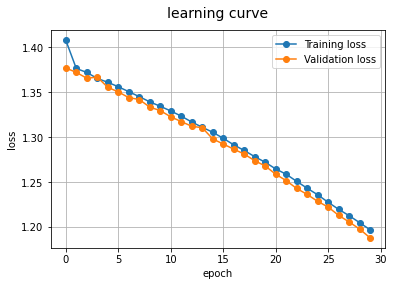

In [ ]:
x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

In [ ]:
losses, f1, accuracy, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Train:       f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Validation:  f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Test:        f1=", f1, "  accuracy=",accuracy)


Train:       f1= 0.5170525228550885   accuracy= 0.589375
Validation:  f1= 0.5587408554896993   accuracy= 0.64
Test:        f1= 0.5368937445649774   accuracy= 0.6090116279069767


#### Σχολιασμός ερωτήματος 1: 
##### Παρατηρούμε ότι τα learning curves των δεδομένων εκπαίδευσης και επαλήθευσης σχεδόν συμπίπτουν, το οποίο είναι αρκετά θετικό για το μοντέλο μας. Αυτό αποτελεί στόχο μας, διότι επιθυμούμε να παρέχουμε δεδομένα που δεν γνωρίζουμε εκ των προτέρων, τα οποία εκφράζονται από τα validation και test dataset. Συνεπώς, έχουμε καλές προοπτικές για γενίκευση του μοντέλου. <br> Ωστόσο, η απόδοση είναι χαμηλή με περίπου 0.51-0.55 f1_score και 0.60 accuracy. Είναι εμφανές ότι τα αποτελέσματα είναι φτωχά και παρόλο που οι καμπύλες των loss ανά epoch είναι καλές, πρέπει να βελτιωθεί η απόδοση του μοντέλου. Επίσης, παρατηρούμε απόκλιση στα accuracy, f1_score, το οποίο φανερώνει ότι η accuracy δεν είναι καλή μετρική, παρόλο που τα δεδομένα είναι ισορροπημένα (η μετρική accuracy αποτυγχάνει στα imbalanced dataset), ενώ η f1 δίνει καλύτερη εικόνα για την απόδοση του μοντέλου, διότι λαμβάνονται υπόψιν τα precision και recall.

# PART 2

In [20]:
x_train = np.load('/content/music_genre_data_di/train/melgrams/X.npy')
y_train_str = np.load('/content/music_genre_data_di/train/melgrams/labels.npy')

x_test = np.load('/content/music_genre_data_di/test/melgrams/X.npy')
y_test_str = np.load('/content/music_genre_data_di/test/melgrams/labels.npy')

x_val = np.load('/content/music_genre_data_di/val/melgrams/X.npy')
y_val_str = np.load('/content/music_genre_data_di/val/melgrams/labels.npy')

y_train, label_mapping = convertLabels(y_train_str)
y_test, _ = convertLabels(y_test_str)
y_val, _ = convertLabels(y_val_str)

train_data = data(x_train, y_train,label_mapping)
train_data.createDataloader(batch_siz=16)
train_dataloader = train_data.getDataloader()

test_data = data(x_test, y_test, label_mapping)
test_data.createDataloader(batch_siz=16)
test_dataloader = test_data.getDataloader()

val_data = data(x_val, y_val, label_mapping)
val_data.createDataloader(batch_siz=16)
val_dataloader = val_data.getDataloader()

In [ ]:
for x,y in train_dataloader:
  print(x.shape)
  break

torch.Size([16, 21, 128])


In [ ]:
class ConvNet(nn.Module):
  def __init__(self, convD, fcD, n_classes):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=convD[0], out_channels=convD[1], kernel_size=(5,5))
    self.conv2 = nn.Conv2d(in_channels=convD[1], out_channels=convD[2], kernel_size=(5,5))
    self.conv3 = nn.Conv2d(in_channels=convD[2], out_channels=convD[3], kernel_size=(5,5))
    self.conv4 = nn.Conv2d(in_channels=convD[3], out_channels=convD[4], kernel_size=(5,5))

    convOut_dim = convD[4] * 5 * 112  
    self.fc1 = nn.Linear(convOut_dim, fcD[0])
    self.fc2 = nn.Linear(fcD[0], fcD[1])
    self.fc3 = nn.Linear(fcD[1], fcD[2])
    self.fc4 = nn.Linear(fcD[2], n_classes)

    self.out_activ_fun = nn.Softmax(dim=1)
    
  def forward(self, x):
    x = x.unsqueeze_(1) # we need to add a dimension for channels. 
    # x shape = [batch_size, n_channels, x_axis_data, y_axis_data]
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.flatten(x,1)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    return x

In [ ]:
# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()) ).to(device)

# declare loss function
weights = torch.tensor([1.0,1.0,1.0,1.0])   # we can expirement with weights of loss function for each optimizer
loss_fun = nn.CrossEntropyLoss(weight=weights).to(device)

# declare optimizer
learning_rate = 0.002
optimizer = torch.optim.SGD(nnet.parameters(), lr=learning_rate)

epochs = 30 
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

Time executed with device cuda :160.12295055389404


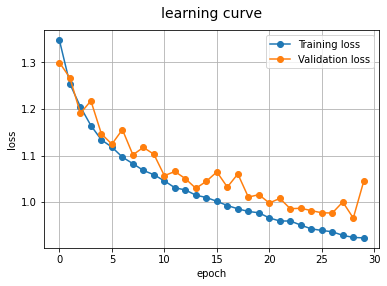

In [ ]:
x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

In [ ]:
losses, f1, accuracy, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Train:       f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Validation:  f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Test:        f1=", f1, " accuracy=",accuracy)


Train:       f1= 0.5834866826305034   accuracy= 0.599375
Validation:  f1= 0.5268397553471628   accuracy= 0.55125
Test:        f1= 0.48868029242884525  accuracy= 0.49709302325581395


##### Παρατηρούμε ότι η εκπαίδευση του δικτύου είναι αρκετά χρονοβόρα και με χαμηλή απόδοση. Αυτό οφείλεται στον μεγάλο αριθμό channels που αυξάνεται στα συνελικτικά επίπεδα και δεν αντισταθμίζεται αυτή η αύξηση με κάποιον τρόπο(πχ με pooling layers ή εφαρμόζοντας stride στα συνελικτικά επίπεδα, το οποίο δεν συνίσταται διότι χάνονται δεδομένα σε αντίθεση με το pooling).

In [ ]:
class ConvNetPool(nn.Module):
  def __init__(self, convD, fcD, n_classes):
    super(ConvNetPool, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=convD[0], out_channels=convD[1], kernel_size=(5,5), padding=2)
    self.conv2 = nn.Conv2d(in_channels=convD[1], out_channels=convD[2], kernel_size=(5,5), padding=2)
    self.conv3 = nn.Conv2d(in_channels=convD[2], out_channels=convD[3], kernel_size=(5,5), padding=2)
    self.conv4 = nn.Conv2d(in_channels=convD[3], out_channels=convD[4], kernel_size=(5,5), padding=2)

    self.maxPool1 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool2 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool3 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool4 = nn.MaxPool2d(kernel_size=(2,2))

    convOut_dim = convD[4] * 1 * 8  
    #convOut_dim = convD[4] * 2 * 16
    self.fc1 = nn.Linear(convOut_dim, fcD[0])
    self.fc2 = nn.Linear(fcD[0], fcD[1])
    self.fc3 = nn.Linear(fcD[1], fcD[2])
    self.fc4 = nn.Linear(fcD[2], n_classes)

    self.out_activ_fun = nn.Softmax(dim=1)
    
  def forward(self, x):
    x = x.unsqueeze_(1) # we need to add a dimension for channels. 
    # x shape = [batch_size, n_channels, x_axis_data, y_axis_data]
    x = self.conv1(x)
    x = self.maxPool1(x)
    x = self.conv2(x)
    x = self.maxPool2(x)
    x = self.conv3(x)
    x = self.maxPool3(x)
    x = self.conv4(x)
    x = self.maxPool4(x)
    
    x = torch.flatten(x,1)  # flatten all dimensions except batch

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    
    return x

##### Με την προσθήκη των pooling και padding η απόδοση του μοντέλου αυξάνεται εμφανώς και τα learning curves είναι πιο ομαλά, συγκλίνοντας το ένα με το άλλο. Ακόμη, ο πιο βασικός λόγος για χρήση του pooling είναι ότι μειώνεται σε μεγάλο βαθμό το μέγεθος των δεδομένων ανά επίπεδο και έτσι η εκπαίδευση γίνεται αρκετά ταχύτερη. Βέβαια, η μείωση των δεδομένων με το pooling πρέπει να περιοριστεί με την προσθήκη padding, καθώς στα πιο βαθιά επίπεδα του δικτύου ενδέχεται να είναι τόσο μειωμένα ώστε να μην είναι δυνατή η εξαγωγή features. Επομένως, αυτά τα δύο στοιχεία 

In [ ]:
# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNetPool( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()) ).to(device)

# declare loss function
weights = torch.tensor([1.0,1.0,1.0,1.0])   # we can expirement with weights of loss function for each optimizer
loss_fun = nn.CrossEntropyLoss(weight=weights).to(device)

# declare optimizer
learning_rate = 0.002
optimizer = torch.optim.SGD(nnet.parameters(), lr=learning_rate) 
#optimizer = torch.optim.SGD(nnet.parameters(), lr=learning_rate, nesterov=True, momentum=0.9) 
#optimizer = torch.optim.ASGD(nnet.parameters(), lr=learning_rate) 
#optimizer = torch.optim.RMSprop(nnet.parameters(), lr=learning_rate) 
#optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adamax(nnet.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adagrad(nnet.parameters(), lr=learning_rate)

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

Time executed with device cuda :27.673105716705322


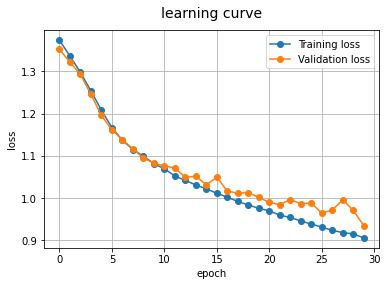

In [ ]:
x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

In [ ]:
losses, f1, accuracy, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Train:       f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Validation:  f1=", f1, "  accuracy=",accuracy)
losses, f1, accuracy, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print("Test:        f1=", f1, "  accuracy=",accuracy)

Train:       f1= 0.6192132040736439   accuracy= 0.63625
Validation:  f1= 0.5891889384225744   accuracy= 0.6075
Test:        f1= 0.5659868688473929   accuracy= 0.5821220930232558


\begin{array}{|c|c|} \hline
Optimizer & F1 \; score & Accuracy  \\ \hline
SGD \\ (lr=0.003) & 0.63 & 0.64  \\ \hline
ASGD \\ (lr=0.003) & 0.61 & 0.60  \\ \hline
SGD-nesterov \\ (lr=0.001 \\ momentum=0.9) & 0.72 & 0.71  \\ \hline
Adam \\ (lr=5e-6) & 0.72 & 0.71 \\\hline
Adamax \\ (lr=1e-5) & 0.71 & 0.70 \\ \hline
Adagrad \\ (lr=2e-4) & 0.69 & 0.69 \\ \hline
\end{array}

##### Οι μετρήσεις αποτελούν τον μέσο από 3 εκπαιδεύσεις του μοντέλου. Επίσης, προσάρμοσα το learning rate ανάλογα με τον εκάστοτε optimizer, καθώς υπήρχε μεγάλη απόκλιση στα αποτελέσματα και αυτό αποτυπωνόταν στα learning curves. <br> Παρατηρούμε ότι τα SGD, ASGD έχουν μικρότερη απόδοση από τους optimizers Adam, Adamax, κτλ. Ωστόσο, για να επιτευχθεί  η απόδοση αυτή χρειάστηκε πειραματισμός με τα learning rates. Είναι εμφανές ότι οι Optimizers της "οικογένειας" Adam αποδίδουν καλύτερα, το οποίο είναι ευνόητο αφού συνδυάζουν σκεπτικά από διάφορους Optimizers(ο adam αποτελεί συνονθύλευμα rmsProp, momentum). Ωστόσο, χρειάζεται προσεκτική επιλογή του βέλτιστου optimizer ανάλογα με την κάθε περίπτωση, διότι ο adam εισάγει και δύο ακόμα υπερπαραμέτρους που πρέπει να γίνουν fine-tune(για τον πειραματισμό άφησα τις default τιμές). Συνεπώς, μπορεί ένας πιο απλός Optimizer να ταιριάζει καλύτερα στο κάθε μοντέλο, ενώ παρατήρησα ότι αποδίδει καλά ο SGD-nesterov. Στην συγκεκριμένη περίπτωση, χρησιμοποιώ Adam στα επόμενα ερωτήματα.

# PART 3

###TASK 1

In [8]:
import random, os

def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

Time executed with device cuda :36.32395005226135
0.7637029162040981 0.7625
0.7157862180699471 0.715
0.7175682849727291 0.7085755813953488


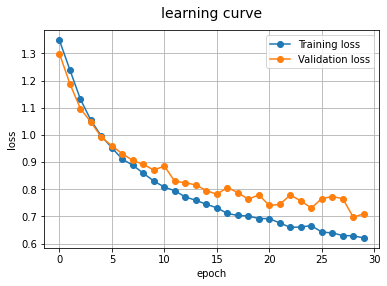

In [ ]:
torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNetPool( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()) ).to(device)

# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 5e-6
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)



Time executed with device cuda :36.10354542732239
0.7637029162040981 0.7625
0.7157862180699471 0.715
0.7175682849727291 0.7085755813953488


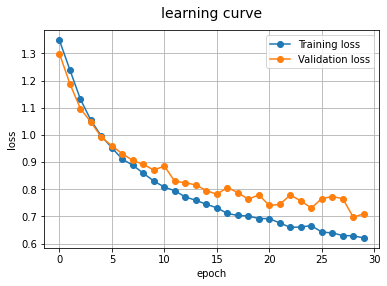

In [ ]:
torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNetPool( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()) ).to(device)

# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 5e-6
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)



###TASK 2

In [ ]:
class ConvNet2(nn.Module):
  def __init__(self, convD, fcD, n_classes, act_fun="relu"):
    super(ConvNet2, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=convD[0], out_channels=convD[1], kernel_size=(5,5), padding=2)
    self.conv2 = nn.Conv2d(in_channels=convD[1], out_channels=convD[2], kernel_size=(5,5), padding=2)
    self.conv3 = nn.Conv2d(in_channels=convD[2], out_channels=convD[3], kernel_size=(5,5), padding=2)
    self.conv4 = nn.Conv2d(in_channels=convD[3], out_channels=convD[4], kernel_size=(5,5), padding=2)

    self.maxPool1 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool2 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool3 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool4 = nn.MaxPool2d(kernel_size=(2,2))

    convOut_dim = convD[4] * 1 * 8  

    self.fc1 = nn.Linear(convOut_dim, fcD[0])
    self.fc2 = nn.Linear(fcD[0], fcD[1])
    self.fc3 = nn.Linear(fcD[1], fcD[2])
    self.fc4 = nn.Linear(fcD[2], n_classes)

    self.out_activ_fun = nn.Softmax(dim=1)
    if act_fun == "relu":
      self.act_fun = nn.ReLU()
    if act_fun == "leaky_relu":
      self.act_fun = nn.LeakyReLU()
    if act_fun == "elu":
      self.act_fun = nn.ELU()
    if act_fun == "gelu":
      self.act_fun = nn.GELU()
    if act_fun == "selu":
      self.act_fun = nn.SELU()
    
    
  def forward(self, x):
    x = x.unsqueeze_(1) # we need to add a dimension for channels. 
    # x shape = [batch_size, n_channels, x_axis_data, y_axis_data]
    x = self.conv1(x)
    x = self.act_fun(x)
    x = self.maxPool1(x)
    x = self.conv2(x)
    x = self.act_fun(x)
    x = self.maxPool2(x)
    x = self.conv3(x)
    x = self.act_fun(x)
    x = self.maxPool3(x)
    x = self.conv4(x)
    x = self.act_fun(x)
    x = self.maxPool4(x)
    
    x = torch.flatten(x,1)  # flatten all dimensions except batch

    x = self.act_fun(x)
    x = self.fc1(x)
    x = self.act_fun(x)
    x = self.fc2(x)
    x = self.act_fun(x)
    x = self.fc3(x)
    x = self.act_fun(x)
    x = self.fc4(x)
    
    return x

Time executed with device cuda :39.02589535713196
0.8392356370477766 0.83875
0.7897645892939333 0.78875
0.7863058283130662 0.7819767441860465


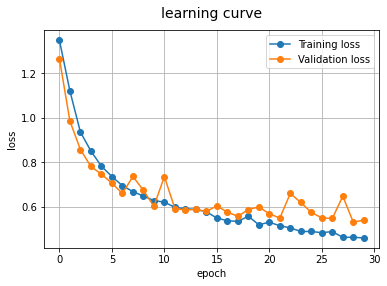

In [ ]:
torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet2( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()), act_fun="gelu" ).to(device)
#nnet = ConvNetPool( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping())).to(device)


# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 15e-6
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)



\begin{array}{|c|c|} \hline
Activation \; function & F1 \; score & Accuracy  \\ \hline
ReLU \\ (lr=15e-6) & 0.74 & 0.74  \\ \hline
Leaky \; ReLU \\ (lr=2e-5) & 0.74 & 0.74  \\ \hline
ELU \\ (lr=lr=15e-6) & 0.784 & 0.777 \\ \hline
GELU \\ (lr=15e-6) & 0.786 & 0.781 \\\hline
SELU \\ (lr=8e-6) & 0.769 & 0.765 \\ \hline
\end{array}

###TASK 4

Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 5.0000e-06.


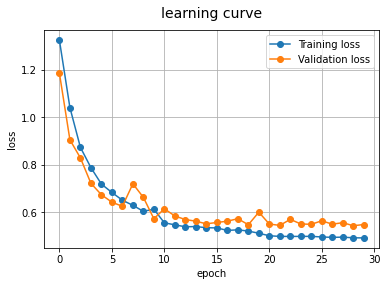

In [ ]:

torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet2( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()), act_fun="gelu" ).to(device)
#nnet = ConvNetPool( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping())).to(device)


# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 2e-5
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
###################################################################################
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25,  verbose=True)
###################################################################################

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False, scheduler=scheduler)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)




##### Τα τελικά σκορ που επιτυγχάνονται με τους learning rate schedulers είναι αρκετά κοντά με σταθερό learning rate. Ωστόσο, υπάρχει περισσότερο ευστάθεια και ομαλότητα στις επιδόσεις ανά εποχή, το οποίο είναι απόρροια του αυτορυθμιζόμενου learning rate. <br> Ειδικότερα, με τη σύγκριση των learning curves χρησιμοποιώντας Adam optimizer, GELU activation function, βλέπουμε ότι χωρις τον scheduler μετά από 5 μόλις epochs η καμπύλη του validation loss παρουσιάζει αλλαγές(διακυμάνσεις), το οποίο φανερώνει πως το learning rate είναι μεγάλο και πρέπει να ελαττωθεί, ώστε να γίνονται μικρότερα βήματα για τη σύγκλιση στην βέλτιστη λύση. <br> Με την χρήση των ExpodentialLR και StepLR είναι εμφανής η βελτίωση του μοντέλου, αφού οι καμπύλες των train, validation είναι αρκετά "κοντά"(δεν αποκλίνουν η μία από την άλλη), το οποίο παρουσιάζει καλές προοπτικές για καλύτερη γενίκευση(αποφυγή του overfitting). Επίσης, είναι πιο ομαλές, έχοντας ως απότοκο την καλύτερη και πιο "προβλέψιμη" εφαρμογή του μοντέλου. <br> Η ακρίβεια και τα σκορ έχουν παραπλήσιες τιμές, αλλά σύμφωνα με τα παραπάνω, το καλύτερο μοντέλο πρέπει να υλοποιείται με scheduler.

![picture](https://drive.google.com/uc?export=view&id=1Qkg2_CosTWDtNlAwlCLel9SNU9LbYtRl)

###TASK 5

In [ ]:
class ConvNet5(nn.Module):
  def __init__(self, convD, fcD, n_classes, act_fun="relu"):
    super(ConvNet5, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=convD[0], out_channels=convD[1], kernel_size=(5,5), padding=2)
    self.conv2 = nn.Conv2d(in_channels=convD[1], out_channels=convD[2], kernel_size=(5,5), padding=2)
    self.conv3 = nn.Conv2d(in_channels=convD[2], out_channels=convD[3], kernel_size=(5,5), padding=2)
    self.conv4 = nn.Conv2d(in_channels=convD[3], out_channels=convD[4], kernel_size=(5,5), padding=2)

    self.maxPool1 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool2 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool3 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool4 = nn.MaxPool2d(kernel_size=(2,2))

    convOut_dim = convD[4] * 1 * 8  

    self.fc1 = nn.Linear(convOut_dim, fcD[0])
    self.fc2 = nn.Linear(fcD[0], fcD[1])
    self.fc3 = nn.Linear(fcD[1], fcD[2])
    self.fc4 = nn.Linear(fcD[2], n_classes)

    self.norm1 = nn.BatchNorm2d(convD[1])
    self.norm2 = nn.BatchNorm2d(convD[2])
    self.norm3 = nn.BatchNorm2d(convD[3])
    self.norm4 = nn.BatchNorm2d(convD[4])

    self.out_activ_fun = nn.Softmax(dim=1)
    if act_fun == "relu":
      self.act_fun = nn.ReLU()
    if act_fun == "leaky_relu":
      self.act_fun = nn.LeakyReLU()
    if act_fun == "elu":
      self.act_fun = nn.ELU()
    if act_fun == "gelu":
      self.act_fun = nn.GELU()
    if act_fun == "selu":
      self.act_fun = nn.SELU()
    
    
  def forward(self, x):
    x = x.unsqueeze_(1) # we need to add a dimension for channels. 
    # x shape = [batch_size, n_channels, x_axis_data, y_axis_data]
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.act_fun(x)
    x = self.maxPool1(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = self.act_fun(x)
    x = self.maxPool2(x)
    x = self.conv3(x)
    x = self.norm3(x)
    x = self.act_fun(x)
    x = self.maxPool3(x)
    x = self.conv4(x)
    x = self.norm4(x)
    x = self.act_fun(x)
    x = self.maxPool4(x)
    
    x = torch.flatten(x,1)  # flatten all dimensions except batch

    x = self.act_fun(x)
    x = self.fc1(x)
    x = self.act_fun(x)
    x = self.fc2(x)
    x = self.act_fun(x)
    x = self.fc3(x)
    x = self.act_fun(x)
    x = self.fc4(x)
    
    return x

Time executed with device cuda :46.07036304473877
0.833457523780807 0.834375
0.8021033214271669 0.80375
0.7716835125788704 0.7718023255813954


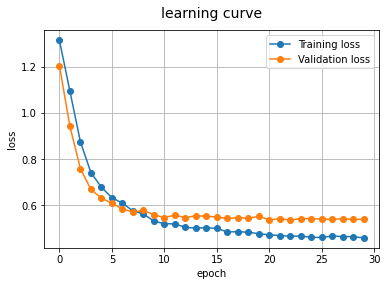

In [ ]:
torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet5( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()), act_fun="gelu" ).to(device)


# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 7e-6
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25)
#scheduler = lr_scheduler.ExpodentialLR(optimizer, gamma=0.9)

epochs = 30
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False, scheduler=scheduler)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)




###TASK 6

In [22]:
class ConvNet6(nn.Module):
  def __init__(self, convD, fcD, n_classes, act_fun="gelu"):
    super(ConvNet6, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=convD[0], out_channels=convD[1], kernel_size=(5,5), padding=2)
    self.conv2 = nn.Conv2d(in_channels=convD[1], out_channels=convD[2], kernel_size=(5,5), padding=2)
    self.conv3 = nn.Conv2d(in_channels=convD[2], out_channels=convD[3], kernel_size=(5,5), padding=2)
    self.conv4 = nn.Conv2d(in_channels=convD[3], out_channels=convD[4], kernel_size=(5,5), padding=2)

    self.maxPool1 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool2 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool3 = nn.MaxPool2d(kernel_size=(2,2))
    self.maxPool4 = nn.MaxPool2d(kernel_size=(2,2))

    convOut_dim = convD[4] * 1 * 8  

    self.fc1 = nn.Linear(convOut_dim, fcD[0])
    self.fc2 = nn.Linear(fcD[0], fcD[1])
    self.fc3 = nn.Linear(fcD[1], fcD[2])
    self.fc4 = nn.Linear(fcD[2], n_classes)

    self.norm1 = nn.BatchNorm2d(convD[1])
    self.norm2 = nn.BatchNorm2d(convD[2])
    self.norm3 = nn.BatchNorm2d(convD[3])
    self.norm4 = nn.BatchNorm2d(convD[4])

    self.drop1 = nn.Dropout(0.5)
    self.drop2 = nn.Dropout(0.5)
    self.drop3 = nn.Dropout(0.5)

    self.out_activ_fun = nn.Softmax(dim=1)
    if act_fun == "relu":
      self.act_fun = nn.ReLU()
    if act_fun == "leaky_relu":
      self.act_fun = nn.LeakyReLU()
    if act_fun == "elu":
      self.act_fun = nn.ELU()
    if act_fun == "gelu":
      self.act_fun = nn.GELU()
    if act_fun == "selu":
      self.act_fun = nn.SELU()
    
    
  def forward(self, x):
    x = x.unsqueeze_(1) # we need to add a dimension for channels. 
    # x shape = [batch_size, n_channels, x_axis_data, y_axis_data]
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.act_fun(x)
    x = self.maxPool1(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = self.act_fun(x)
    x = self.maxPool2(x)
    x = self.conv3(x)
    x = self.norm3(x)
    x = self.act_fun(x)
    x = self.maxPool3(x)
    x = self.conv4(x)
    x = self.norm4(x)
    x = self.act_fun(x)
    x = self.maxPool4(x)
    
    x = torch.flatten(x,1)  # flatten all dimensions except batch

    x = self.act_fun(x)
    x = self.drop1(x)
    x = self.fc1(x)
    x = self.act_fun(x)
    x = self.drop2(x)
    x = self.fc2(x)
    x = self.act_fun(x)
    x = self.drop3(x)
    x = self.fc3(x)
    x = self.act_fun(x)
    x = self.fc4(x)
    
    return x

Time executed with device cuda :97.44499850273132
0.8378217824039045 0.84
0.7901827668904907 0.79375
0.7656233850129199 0.7703488372093024


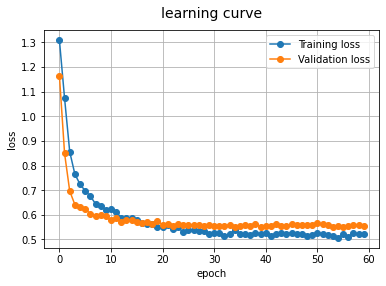

In [ ]:
torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet6( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()), act_fun="gelu" ).to(device)


# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 3e-5
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 60
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=False, scheduler=scheduler)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(epochs)]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses, f1, acc, conf_matrix = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1,acc)
losses, f1, acc, conf_matrix = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1,acc)
losses, f1, acc, conf_matrix = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1,acc)




#####Παρατηρούμε ότι οι αποδόσεις αυξάνονται ελάχιστα, αλλά τα learning curves γίνονται ακόμα πιο ομαλά και συγκλίνουν αρκετά μεταξύ τους, το οποίο σημαίνει ότι δεν υπάρχει overfitting και γίνεται καλύτερο generalization. <br> Ωστόσο, ενώ τα αποτελέσματα φαίνονται ότι είναι σχεδόν παραπλήσια με τα προηγούμενα βήματα, με τις τελευταίες προσθήκες του regularization και του dropout, τα αποτελέσματα των training, validation και test dataset είναι αρκετά "κοντά" και δεν αποκλίνουν, το οποίο είναι και το βέλτιστο για το μοντέλο μας. Ακόμη, με τη χρήση του l2 regularization πέραν της αύξησης της απόδοσης, περιορίζεται το overfitting, καθώς αποφεύγονται μεγάλες τιμές βαρών. Μάλιστα, παρά τον διπλασιασμό του αριθμού των εποχών, δεν γίνεται Overfitting και τα αποτελέσματα παραμένουν με καλές τιμές. Επιπρόσθετα, η συμβολή του Dropout στην αποφυγή του Overfitting είναι σημαντική, αλλά και στην βελτίωση της ανθεκτικότητας του μοντέλου στον θόρυβο, το οποίο επιτυγχάνεται με το τυχαίο "drop" κόμβων.  

###TASK 7

Time executed with device cuda :101.30824542045593
0.8415278732260381 0.843125
0.7804411305016611 0.78375
0.7651124973362102 0.7688953488372093


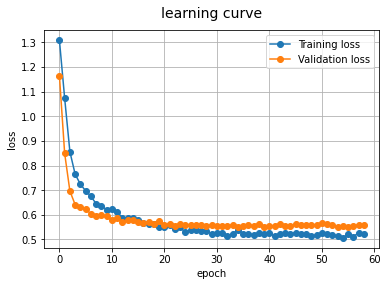

In [36]:
train_data = data(x_train, y_train,label_mapping)
train_data.createDataloader(batch_siz=16)
train_dataloader = train_data.getDataloader()

test_data = data(x_test, y_test, label_mapping)
test_data.createDataloader(batch_siz=16)
test_dataloader = test_data.getDataloader()

val_data = data(x_val, y_val, label_mapping)
val_data.createDataloader(batch_siz=16)
val_dataloader = val_data.getDataloader()

torch_seed()

# Convolution channels
convD =  [1, 16, 32, 64, 128]
#
fcD = [1024, 256, 32]
# create neural net model
nnet = ConvNet6( convD=convD, fcD=fcD, n_classes = len(train_data.getLabelMapping()), act_fun="gelu" ).to(device)


# declare loss function
loss_fun = nn.CrossEntropyLoss().to(device)

# declare optimizer
learning_rate = 3e-5
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 60
start_time = time.time()
losses_train, losses_eval, f1_scores= nnLoop(optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader = val_dataloader, loss_fun=loss_fun, model=nnet, num_epochs=epochs, early_stopping=True, scheduler=scheduler)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
end_time = time.time()
print('Time executed with device ' + str(device) + ' :'+ str(end_time-start_time))

x_axis = [i for i in range(len(losses_train))]
learning_curves(x_axis, losses_train, x_axis, losses_eval)

losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(train_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(val_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)
losses_test, f1_test, accuracy_test, conf_matrix_test = eval_loop(test_data.getDataloader(), model=nnet, loss_fun=loss_fun, isTest=True)
print(f1_test,accuracy_test)




\begin{array}{|c|c|} \hline
Batch \; size & F1 \; score & Accuracy & Time \; (sec) \\ \hline
2 & 0.657 & 0.695 & 741 \\ \hline
4 & 0.759 & 0.763 & 362\\ \hline
8 & 0.771 & 0.774 & 201 \\ \hline
16 & 0.765 & 0.770 & 101 \\ \hline
32 & 0.760 & 0.765 & 53\\\hline
64 & 0.740 & 0.749 & 30 \\ \hline
128 & 0.709 & 0.723 & 25 \\ \hline
\end{array}

#####Αρχικά, παρατηρούμε ότι όσο μικρότερο **batch size** εφαρμόζουμε, τόσο περισσότερο χρόνο χρειάζεται το δίκτυο προκειμένου να εκπαιδευτεί, το οποίο είναι ευνόητο, καθώς πρέπει να κάνει το forward και backward κομμάτι αρκετά περισσότερες φορές. Όσον αφορά την απόδοση είναι εμφανές ότι για πολύ μικρές τιμές του batch size, η απόδοση και η αξιοπιστία του μοντέλου πέφτει, ενώ το ίδιο συμβαίνει και για πολύ μεγάλες τιμές. Τα καλύτερα αποτελέσματα τα λαμβάνουμε για "ενδιάμεσες" τιμές (16 batch size), με τον χρόνο εκπαίδευσης να μην είναι αρκετά μεγάλος και με τα f1 scores, learning curves να παρουσιάζουν τα βέλτιστα αποτελέσματα.

##### Το **early stoppping** μπορεί να έχει σημαντικό αντίκτυπο στο μοντέλο μας αν χρησιμοποιηθεί σωστά. Η απόδοση του μοντέλου δεν αυξάνεται με την εκπαίδευση με περισσότερες εποχές, αλλά αντιθέτως μπορεί να παρατηρηθεί overfitting. Γι'αυτό, αν η απόδοση του μοντέλου δεν βελτιώνεται και το loss των δεδομένων επαλήθευσης αυξάνεται σε διαδοχικές εποχές(patience), τότε μπορούμε να σταματήσουμε την εκπαίδευση του μοντέλου στο κατάλληλο στιγμιότυπο. Έτσι, όχι μόνο αποφεύγεται το Overfitting, αλλά και εξοικονομούμε αρκετό χρόνο και πόρους, ενώ ο αριθμός των εποχών απομακρύνεται από το σύνολο των υπερπαραμέτρων που πρέπει να πειραματιστούμε, αφού αυτοματοποιείται η διαδικασία. Βέβαια, πρέπει να θέσουμε συνετή τιμή patience, ώστε να μην είναι ούτε αρκετά μικρή ώστε να γίνεται underperfoming, ούτε αρκετά μεγάλη, ώστε να μην γίνεται early stop.